# Predspracovanie dát

In [3]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from pyspark.ml.feature import StringIndexer , OneHotEncoder, Bucketizer, VectorAssembler, StandardScaler
from pyspark.sql.functions import col, log2, sum, count, when
from integration.integration import integration
from pyspark.sql.functions import median
from pyspark.sql import SparkSession
from collections import Counter

In [4]:
spark = SparkSession.builder.appName("preprocessing").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [5]:
df_train, df_test = integration()
df_train = df_train.drop("Accident_Index", "Date")
df_test = df_test.drop("Accident_Index","Date")

#### Zistenie, ktoré stĺpce sú kvantitatívne a kategorické

In [6]:
types = df_train.dtypes
print(types)

[('Location_Easting_OSGR', 'int'), ('Location_Northing_OSGR', 'int'), ('Longitude', 'double'), ('Latitude', 'double'), ('Police_Force', 'int'), ('Accident_Severity', 'int'), ('Number_of_Vehicles', 'int'), ('Number_of_Casualties', 'int'), ('Day_of_Week', 'int'), ('Time', 'timestamp'), ('Local_Authority_(District)', 'int'), ('Local_Authority_(Highway)', 'string'), ('1st_Road_Class', 'int'), ('1st_Road_Number', 'int'), ('Road_Type', 'int'), ('Speed_limit', 'int'), ('Junction_Detail', 'int'), ('Junction_Control', 'int'), ('2nd_Road_Class', 'int'), ('2nd_Road_Number', 'int'), ('Pedestrian_Crossing-Human_Control', 'int'), ('Pedestrian_Crossing-Physical_Facilities', 'int'), ('Light_Conditions', 'int'), ('Weather_Conditions', 'int'), ('Road_Surface_Conditions', 'int'), ('Special_Conditions_at_Site', 'int'), ('Carriageway_Hazards', 'int'), ('Urban_or_Rural_Area', 'int'), ('Did_Police_Officer_Attend_Scene_of_Accident', 'int'), ('LSOA_of_Accident_Location', 'string'), ('Vehicle_Reference', 'int')

In [7]:
counts = Counter()

for dtype in types:
    counts[dtype[1]] += 1

print(counts)

Counter({'int': 59, 'double': 2, 'string': 2, 'timestamp': 1})


#### Vypočítanie základných štatistík pre kvantitatívne stĺpce

In [8]:
def get_int(df):
    int_columns = []

    for column, data_type in df.dtypes:
        if data_type == "int":
            int_columns.append(column)
    return int_columns

In [9]:
def show_stats(df, columns, batch_size=4):
    for i in range(0, len(columns), batch_size):
        df.describe(columns[i:i+batch_size]).show()

show_stats(df_train, get_int(df_train))

+-------+---------------------+----------------------+------------------+------------------+
|summary|Location_Easting_OSGR|Location_Northing_OSGR|      Police_Force| Accident_Severity|
+-------+---------------------+----------------------+------------------+------------------+
|  count|               300276|                300276|            300293|            300293|
|   mean|      438255.11356885|    300105.18741757586| 30.78688480916971|2.8231294102759636|
| stddev|    94748.83907367043|    157397.67714086492|24.743146328252084|0.4288013609691326|
|    min|                65860|                 10560|                 1|                 1|
|    max|               655370|               1191500|                98|                 3|
+-------+---------------------+----------------------+------------------+------------------+

+-------+------------------+--------------------+------------------+--------------------------+
|summary|Number_of_Vehicles|Number_of_Casualties|       Day_of_Wee

#### Zobrazenie histogramu pre kategorické atribúty

In [10]:
df_train.groupby("Local_Authority_(Highway)").count().orderBy("count", ascending=False).show()

+-------------------------+-----+
|Local_Authority_(Highway)|count|
+-------------------------+-----+
|                E10000016| 9067|
|                E10000030| 8536|
|                E10000017| 7218|
|                E10000012| 6495|
|                E10000015| 6219|
|                E08000025| 5805|
|                E10000014| 5748|
|                E10000028| 5051|
|                E10000019| 4289|
|                E08000035| 4230|
|                E10000024| 4218|
|                E10000007| 4170|
|                E10000020| 3831|
|                E10000032| 3822|
|                E10000023| 3772|
|                E10000008| 3671|
|                E10000029| 3628|
|                E10000003| 3550|
|                E10000025| 3258|
|                E08000032| 3116|
+-------------------------+-----+
only showing top 20 rows



In [11]:
df_train.groupby("LSOA_of_Accident_Location").count().orderBy("count", ascending=False).show()

+-------------------------+-----+
|LSOA_of_Accident_Location|count|
+-------------------------+-----+
|                     NULL|19875|
|                E01024597|  335|
|                E01000004|  308|
|                E01018648|  252|
|                E01023722|  251|
|                E01011365|  244|
|                E01023584|  211|
|                E01030458|  190|
|                E01023725|  170|
|                E01004736|  164|
|                E01005131|  160|
|                E01018465|  154|
|                E01016481|  153|
|                E01002444|  152|
|                E01029317|  148|
|                E01023732|  135|
|                E01018337|  130|
|                E01006650|  128|
|                E01017620|  128|
|                E01008440|  127|
+-------------------------+-----+
only showing top 20 rows



## Chýbajúce hodnoty

In [12]:
df_train.select([count(when(col(c).isNull(), c)).alias(c) for c in df_train.columns]).show()

+---------------------+----------------------+---------+--------+------------+-----------------+------------------+--------------------+-----------+----+--------------------------+-------------------------+--------------+---------------+---------+-----------+---------------+----------------+--------------+---------------+---------------------------------+---------------------------------------+----------------+------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-------------------------+-----------------+------------------+--------------+---------------+---------------+--------------------+-----------------+-------------------+-------------------+-------------+----------------------+----------------------------------+-------------+-----------------------+------------+-----------------------+-----------------+--------------------------------+-----------------+------------------------+--

## Odstranenie atribútov

In [13]:
df_train = df_train.drop("Accident_Index", "Date", "Time", "Longitude", "Latitude", "LSOA_of_Accident_Location")
df_test = df_test.drop("Accident_Index","Date", "Time", "Longitude", "Latitude", "LSOA_of_Accident_Location")

## Nahradenie chýbajúcich hodnôt mediánom

In [14]:
def fillna_median(df, include=None):
    if include is None:
        include = set()
    medians = df.agg(*(median(x).alias(x) for x in df.columns if x in include))
    return df.fillna(medians.first().asDict())


df_train = fillna_median(df_train, ['Location_Easting_OSGR', 'Location_Northing_OSGR'])
df_test  = fillna_median(df_test, ['Location_Easting_OSGR', 'Location_Northing_OSGR'])

In [15]:
df_train.select([count(when(col(c).isNull(), c)).alias(c) for c in df_train.columns]).show()

+---------------------+----------------------+------------+-----------------+------------------+--------------------+-----------+--------------------------+-------------------------+--------------+---------------+---------+-----------+---------------+----------------+--------------+---------------+---------------------------------+---------------------------------------+----------------+------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-----------------+------------------+--------------+---------------+---------------+--------------------+-----------------+-------------------+-------------------+-------------+----------------------+----------------------------------+-------------+-----------------------+------------+-----------------------+-----------------+--------------------------------+-----------------+------------------------+-------------------------+--------------------------

## Nominálne na kvantitatívne pomocou One-hot encoding

In [16]:
categorical_attributes = [x for x, y in df_train.dtypes if y == 'string']
index_output_cols = [x + "_SI" for x in categorical_attributes]
ohe_output_cols  = [x + "_OHE" for x in categorical_attributes]

indexer = StringIndexer(inputCols=categorical_attributes , outputCols=index_output_cols, handleInvalid="skip")
df_train = indexer.fit(df_train).transform(df_train)

ohe = OneHotEncoder(inputCols=index_output_cols ,outputCols =ohe_output_cols)
df_train = ohe.fit(df_train).transform(df_train)

In [17]:
df_train = df_train.drop(*index_output_cols)
df_train = df_train.drop(*categorical_attributes)

df_train.show(5)

+---------------------+----------------------+------------+-----------------+------------------+--------------------+-----------+--------------------------+--------------+---------------+---------+-----------+---------------+----------------+--------------+---------------+---------------------------------+---------------------------------------+----------------+------------------+-----------------------+--------------------------+-------------------+-------------------+-------------------------------------------+-----------------+------------------+--------------+---------------+---------------+--------------------+-----------------+-------------------+-------------------+-------------+----------------------+----------------------------------+-------------+-----------------------+------------+-----------------------+-----------------+--------------------------------+-----------------+------------------------+-------------------------+---------------------------+------------------------

## Náhrada numerických atribútov nominálnymi

In [18]:
# Add this code to a new cell after the "Náhrada numerických atribútov nominálnymi" section
# This will show the distinct values and their frequencies

# For Vehicle_Type
print("===== Vehicle_Type Distribution =====")
df_train.select("Vehicle_Type").distinct().orderBy("Vehicle_Type").show(100)
print("Count of distinct Vehicle_Type values:", df_train.select("Vehicle_Type").distinct().count())

vehicle_type_counts = df_train.groupBy("Vehicle_Type") \
                             .count() \
                             .orderBy("count", ascending=False)
print("Top 20 most common Vehicle_Type values:")
vehicle_type_counts.show(20)

# For Engine_Capacity_(CC)
print("\n===== Engine_Capacity_(CC) Distribution =====")
# Show some basic statistics
df_train.select("Engine_Capacity_(CC)").summary("min", "25%", "50%", "75%", "max").show()

# Show histogram-like distribution by binning
print("Engine capacity distribution by ranges:")
ranges = [(-1, -1), (0, 999), (1000, 1499), (1500, 1999), (2000, 2499), 
          (2500, 2999), (3000, 4999), (5000, float("inf"))]

for start, end in ranges:
    if end == float("inf"):
        count = df_train.filter(col("Engine_Capacity_(CC)") >= start).count()
        print(f"  {start}+ cc: {count} vehicles")
    else:
        count = df_train.filter((col("Engine_Capacity_(CC)") >= start) & 
                                (col("Engine_Capacity_(CC)") <= end)).count()
        print(f"  {start}-{end} cc: {count} vehicles")

# Common engine capacity values
engine_capacity_counts = df_train.groupBy("Engine_Capacity_(CC)") \
                                .count() \
                                .orderBy("count", ascending=False)
print("\nTop 20 most common Engine_Capacity_(CC) values:")
engine_capacity_counts.show(100)

===== Vehicle_Type Distribution =====
+------------+
|Vehicle_Type|
+------------+
|          -1|
|           1|
|           2|
|           3|
|           4|
|           5|
|           8|
|           9|
|          10|
|          11|
|          16|
|          17|
|          18|
|          19|
|          20|
|          21|
|          22|
|          90|
|          97|
|          98|
+------------+

Count of distinct Vehicle_Type values: 20
Top 20 most common Vehicle_Type values:
+------------+------+
|Vehicle_Type| count|
+------------+------+
|           9|230479|
|          19| 13801|
|           1| 13334|
|          11|  7493|
|           5|  7263|
|          21|  6242|
|           3|  5397|
|           8|  5134|
|           2|  2775|
|          90|  2238|
|          20|  2188|
|           4|  2046|
|          10|  1052|
|          17|   578|
|          16|   126|
|          -1|    45|
|          98|    38|
|          22|    26|
|          18|    20|
|          97|    18|
+------------

In [19]:
driver_age_splits = [-float("inf"), 18, 25, 40, 60, float("inf")]
driver_age_bucketizer = Bucketizer(splits=driver_age_splits, inputCol="Age_of_Driver", outputCol="Age_of_Driver_Cat", handleInvalid="skip")

vehicle_age_splits = [-float("inf"), 0, 2, 6, 11, float("inf")]
vehicle_age_bucketizer = Bucketizer(splits=vehicle_age_splits, inputCol="Age_of_Vehicle", outputCol="Age_of_Vehicle_Cat", handleInvalid="skip")

engine_capacity_splits = [-float("inf"), -1, 0, 1000, 2000, 3000, 5000, 8000, float("inf")]
engine_bucketizer = Bucketizer(splits=engine_capacity_splits, inputCol="Engine_Capacity_(CC)", outputCol="Engine_Size_Cat", handleInvalid="skip")

vehicle_type_splits = [-float("inf"), 0, 1.5, 2.5, 3.5, 4.5, 5.5, 7, 8.5, 9.5, 10.5, 11.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5, 90.5, float("inf")]
vehicle_type_bucketizer = Bucketizer(splits=vehicle_type_splits, inputCol="Vehicle_Type", outputCol="Vehicle_Type_Cat", handleInvalid="keep")

for col_name in ["Age_of_Driver_Cat", "Age_of_Vehicle_Cat", "Engine_Size_Cat", "Vehicle_Type_Cat"]:
    if col_name in df_train.columns:
        df_train = df_train.drop(col_name)
    if col_name in df_test.columns:
        df_test = df_test.drop(col_name)

df_train = driver_age_bucketizer.transform(df_train)
df_train = vehicle_age_bucketizer.transform(df_train)
df_train = engine_bucketizer.transform(df_train)
df_train = vehicle_type_bucketizer.transform(df_train)

df_test = driver_age_bucketizer.transform(df_test)
df_test = vehicle_age_bucketizer.transform(df_test)
df_test = engine_bucketizer.transform(df_test)
df_test = vehicle_type_bucketizer.transform(df_test)

print("DataFrame schema after binning:")
df_train.printSchema()
print("Example data after binning:")
df_train.select(
    "Age_of_Driver", "Age_of_Driver_Cat", 
    "Age_of_Vehicle", "Age_of_Vehicle_Cat",
    "Engine_Capacity_(CC)", "Engine_Size_Cat",
    "Vehicle_Type", "Vehicle_Type_Cat"
).show(5)

DataFrame schema after binning:
root
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Day_of_Week: integer (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- 1st_Road_Class: integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Road_Type: integer (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Detail: integer (nullable = true)
 |-- Junction_Control: integer (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2nd_Road_Number: integer (nullable = true)
 |-- Pedestrian_Crossing-Human_Control: integer (nullable = true)
 |-- Pedestrian_Crossing-Physical_Facilities: integer (nullable = true)
 |-- Light_Conditions: integer (nullable 

## Informačný zisk

Calculating Information Gain with respect to 'Accident_Severity':
  IG(Location_Easting_OSGR): 0.2826
  IG(Location_Northing_OSGR): 0.3242
  IG(Police_Force): 0.0094
  IG(Number_of_Vehicles): 0.0162
  IG(Number_of_Casualties): 0.0265
  IG(Day_of_Week): 0.0014
  IG(Local_Authority_(District)): 0.0205
  IG(1st_Road_Class): 0.0028
  IG(1st_Road_Number): 0.0369
  IG(Road_Type): 0.0042
  IG(Speed_limit): 0.0178
  IG(Junction_Detail): 0.0115
  IG(Junction_Control): 0.0099
  IG(2nd_Road_Class): 0.0099
  IG(2nd_Road_Number): 0.0236
  IG(Pedestrian_Crossing-Human_Control): 0.0001
  IG(Pedestrian_Crossing-Physical_Facilities): 0.0019
  IG(Light_Conditions): 0.0068
  IG(Weather_Conditions): 0.0018
  IG(Road_Surface_Conditions): 0.0001
  IG(Special_Conditions_at_Site): 0.0003
  IG(Carriageway_Hazards): 0.0007
  IG(Urban_or_Rural_Area): 0.0141
  IG(Did_Police_Officer_Attend_Scene_of_Accident): 0.0142
  IG(Vehicle_Reference): 0.0090
  IG(Casualty_Reference): 0.0144
  IG(Casualty_Class): 0.0034
  IG(

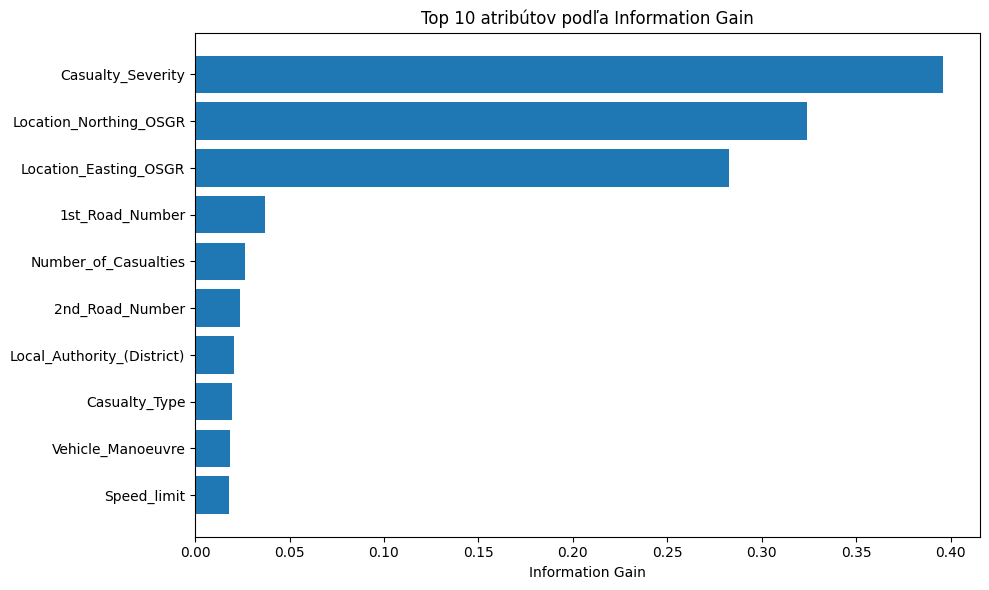

In [21]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

def calculate_entropy(df, group_col):
    """Calculates the entropy for a given column."""
    total_count = df.count()
    entropy = df.groupBy(group_col) \
                .agg((F.count("*") / total_count).alias("prob")) \
                .select(F.sum(when(col("prob") > 0, -col("prob") * log2(col("prob")))).alias("entropy")) \
                .first()["entropy"]
    if entropy is None:
        return 0.0
    return entropy

def calculate_information_gain(df, attribute_col, target_col):
    """Calculates the Information Gain of an attribute column with respect to a target column."""
    total_count = df.count()

    total_entropy = calculate_entropy(df, target_col)

    conditional_entropy_df = df.groupBy(attribute_col, target_col) \
                               .agg(F.count("*").alias("attr_target_count")) \
                               .join(df.groupBy(attribute_col).agg(F.count("*").alias("attr_count")), on=attribute_col) \
                               .withColumn("cond_prob", col("attr_target_count") / col("attr_count")) \
                               .select(attribute_col, "attr_count",
                                       when(col("cond_prob") > 0, -col("cond_prob") * log2(col("cond_prob"))).alias("term")) \
                               .groupBy(attribute_col, "attr_count") \
                               .agg(F.sum("term").alias("entropy_attr_val")) \
                               .withColumn("attr_prob", col("attr_count") / total_count) \
                               .select(F.sum(col("attr_prob") * col("entropy_attr_val")).alias("conditional_entropy"))

    conditional_entropy = conditional_entropy_df.first()["conditional_entropy"]
    if conditional_entropy is None:
        conditional_entropy = 0.0

    information_gain = total_entropy - conditional_entropy
    return information_gain

target_column = "Accident_Severity"

cols_for_ig = [col for col in df_train.columns if col != target_column]

print(f"Calculating Information Gain with respect to '{target_column}':")

ig_results = {}


for attr_col in cols_for_ig:
    if attr_col in df_train.columns:
        ig = calculate_information_gain(df_train, attr_col, target_column)
        ig_results[attr_col] = ig
        print(f"  IG({attr_col}): {ig:.4f}")
    else:
        print(f"  Column '{attr_col}' not found in df_train. Skipping.")


# Plotting the top 10 attributes with the highest Information Gain
sorted_ig = sorted(ig_results.items(), key=lambda x: x[1], reverse=True)[:10]
attributes, gains = zip(*sorted_ig)

plt.figure(figsize=(10, 6))
plt.barh(attributes, gains)
plt.xlabel("Information Gain")
plt.title("Top 10 atribútov podľa Information Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Normalizácia pomocou StandardScaler - Vypočítanie štatistík pre numerické atribúty

In [22]:
numerical_cols_to_scale = [
    'Location_Easting_OSGR',
    'Location_Northing_OSGR',
    'Police_Force',
    'Accident_Severity',
    'Number_of_Vehicles',
    'Number_of_Casualties',
    'Day_of_Week',
    'Local_Authority_(District)',
    '1st_Road_Class',
    '1st_Road_Number',
    'Road_Type',
    'Speed_limit',
    'Junction_Detail',
    'Junction_Control',
    '2nd_Road_Class',
    '2nd_Road_Number',
    'Pedestrian_Crossing-Human_Control',
    'Pedestrian_Crossing-Physical_Facilities',
    'Light_Conditions',
    'Weather_Conditions',
    'Road_Surface_Conditions',
    'Special_Conditions_at_Site',
    'Carriageway_Hazards',
    'Urban_or_Rural_Area',
    'Did_Police_Officer_Attend_Scene_of_Accident',
    'Vehicle_Reference',
    'Casualty_Reference',
    'Casualty_Class',
    'Sex_of_Casualty',
    'Age_of_Casualty',
    'Age_Band_of_Casualty',
    'Casualty_Severity',
    'Pedestrian_Location',
    'Pedestrian_Movement',
    'Car_Passenger',
    'Bus_or_Coach_Passenger',
    'Pedestrian_Road_Maintenance_Worker',
    'Casualty_Type',
    'Casualty_Home_Area_Type',
    'Towing_and_Articulation',
    'Vehicle_Manoeuvre',
    'Vehicle_Location-Restricted_Lane',
    'Junction_Location',
    'Skidding_and_Overturning',
    'Hit_Object_in_Carriageway',
    'Vehicle_Leaving_Carriageway',
    'Hit_Object_off_Carriageway',
    '1st_Point_of_Impact',
    'Was_Vehicle_Left_Hand_Drive?',
    'Journey_Purpose_of_Driver',
    'Sex_of_Driver',
    'Age_Band_of_Driver',
    'Propulsion_Code',
    'Driver_IMD_Decile',
    'Driver_Home_Area_Type'
]

# Filter out columns that might not be present in the DataFrame at this stage
existing_numerical_cols = [col_name for col_name, dtype in df_train.dtypes 
                          if col_name in numerical_cols_to_scale and dtype in ['int', 'double']]

if not existing_numerical_cols:
    print("No numerical columns found for scaling.")
else:
    print(f"Numerical columns selected for scaling: {existing_numerical_cols}")

    assembler_numerical = VectorAssembler(
        inputCols=existing_numerical_cols,
        outputCol="numerical_features_vec",
        handleInvalid="skip" 
    )
    df_train = assembler_numerical.transform(df_train)
    df_test = assembler_numerical.transform(df_test)

    scaler = StandardScaler(
        inputCol="numerical_features_vec",
        outputCol="scaled_numerical_features",
        withStd=True, 
        withMean=True 
    )

    scaler_model = scaler.fit(df_train)

    df_train = scaler_model.transform(df_train)
    df_test = scaler_model.transform(df_test)

    print("Numerical features scaled using StandardScaler.")
    df_train.select("numerical_features_vec", "scaled_numerical_features").show(5, truncate=False)

Numerical columns selected for scaling: ['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Day_of_Week', 'Local_Authority_(District)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Vehicle_Reference', 'Casualty_Reference', 'Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location', 'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type', 'Casualty_Home_Area_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Veh

## Odstránenie irelevantných atribútov

In [24]:
THRESHOLD = 0.009

low_ig_cols = [col for col, ig in ig_results.items() if ig < THRESHOLD]

df_train = df_train.drop(*low_ig_cols)
df_test = df_test.drop(*low_ig_cols)

print("Columns with IG < 0.009 were removed:")
for col in low_ig_cols:
    print(f" - {col} (IG: {ig_results[col]:.4f})")


Columns with IG < 0.009 were removed:
 - Day_of_Week (IG: 0.0014)
 - 1st_Road_Class (IG: 0.0028)
 - Road_Type (IG: 0.0042)
 - Pedestrian_Crossing-Human_Control (IG: 0.0001)
 - Pedestrian_Crossing-Physical_Facilities (IG: 0.0019)
 - Light_Conditions (IG: 0.0068)
 - Weather_Conditions (IG: 0.0018)
 - Road_Surface_Conditions (IG: 0.0001)
 - Special_Conditions_at_Site (IG: 0.0003)
 - Carriageway_Hazards (IG: 0.0007)
 - Casualty_Class (IG: 0.0034)
 - Sex_of_Casualty (IG: 0.0049)
 - Age_of_Casualty (IG: 0.0045)
 - Age_Band_of_Casualty (IG: 0.0037)
 - Pedestrian_Location (IG: 0.0033)
 - Pedestrian_Movement (IG: 0.0034)
 - Car_Passenger (IG: 0.0007)
 - Bus_or_Coach_Passenger (IG: 0.0002)
 - Pedestrian_Road_Maintenance_Worker (IG: 0.0003)
 - Casualty_Home_Area_Type (IG: 0.0026)
 - Towing_and_Articulation (IG: 0.0012)
 - Vehicle_Location-Restricted_Lane (IG: 0.0003)
 - Skidding_and_Overturning (IG: 0.0055)
 - Hit_Object_in_Carriageway (IG: 0.0012)
 - Hit_Object_off_Carriageway (IG: 0.0062)
 - Wa

In [27]:
print("Remaining columns after filtering (IG ≥ 0.009):")
for col_name in df_train.columns:
    print(f" - {col_name}")

Remaining columns after filtering (IG ≥ 0.009):
 - Location_Easting_OSGR
 - Location_Northing_OSGR
 - Police_Force
 - Accident_Severity
 - Number_of_Vehicles
 - Number_of_Casualties
 - Local_Authority_(District)
 - 1st_Road_Number
 - Speed_limit
 - Junction_Detail
 - Junction_Control
 - 2nd_Road_Class
 - 2nd_Road_Number
 - Urban_or_Rural_Area
 - Did_Police_Officer_Attend_Scene_of_Accident
 - Vehicle_Reference
 - Casualty_Reference
 - Casualty_Severity
 - Casualty_Type
 - Vehicle_Type
 - Vehicle_Manoeuvre
 - Junction_Location
 - Vehicle_Leaving_Carriageway
 - 1st_Point_of_Impact
 - Engine_Capacity_(CC)
 - Local_Authority_(Highway)_OHE
 - Vehicle_Type_Cat
 - numerical_features_vec
 - scaled_numerical_features


# TOTO BY MALO BYT AKO POSLEDNE - PASS DO MODELU

In [ ]:
assembler = VectorAssembler(inputCols=["color_ohe", "other_feature1", "other_feature2"], outputCol="features")
df_model = assembler.transform(df_encoded)

# TODO:
- [x] Informačný zisk - F
- [x] Nahradiť chýbajúce hodnoty - M
- [x] Kvantitívne atribúty na nominálne (neviem prečo) - F
- [x] Normalizácia - StandardScaler - F
- [x] One-hot encoding - M
- [ ] Odstrániť irelevantné atribúty - J

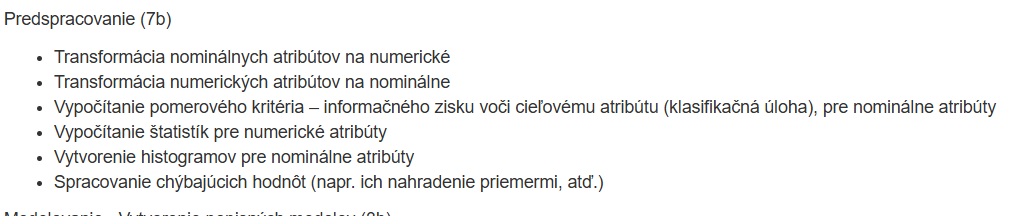